### Importing the dataset

In [17]:
import os
import struct
import numpy as np
from matplotlib import pyplot as plt 

In [31]:
def read(dataset = "training", path = "."):
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        print("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        _, __, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

def show(image):
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.gray)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

In [39]:
train = read('training', 'MNIST'); test = read('testing', 'MNIST')

In [40]:
img_train = []
lbl_train = []
img_test = []
lbl_test = []
for temp in train:
    img_train.append(temp[1])
    lbl_train.append(temp[0])

for temp in test:
    img_test.append(temp[1])
    lbl_test.append(temp[0])

img_train = np.array(img_train)
lbl_train = np.array(lbl_train)
img_test = np.array(img_test)
lbl_test = np.array(lbl_test)

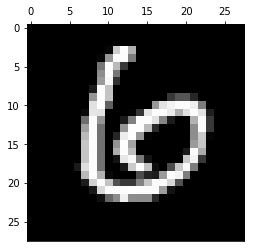

6


In [41]:
show(img_test[11])
print(lbl_test[11])

# The Multilayer feedforward neural network